#  Volatility models

In [1]:
import arch
from arch.__future__ import reindexing

import wrds
import pandas
import numpy
import math
import scipy.stats

from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.tsaplots import acf, plot_acf, pacf, plot_pacf
from scipy.optimize import minimize

from matplotlib import pyplot as plt

In [2]:
conn = wrds.Connection(wrds_username='ashelaine')
FF3F = conn.get_table(library='ff_all',table='factors_monthly',coerce_float=True)
FF3F['month'] = pandas.to_datetime(FF3F['date']).dt.to_period('M')
FF3F = FF3F.drop('date',axis=1).set_index('month')
FF3F = FF3F['1963-07':'2001-07']

Loading library list...
Done


We will look at returns to three basic strategies in the stock market. 

We will measure all three as *log* returns, to be consistent with our examples from class, though this makes very little difference to the results. Remember that if the return in any date is $r$, then the log return is $\ln(1+r)$.

**UMD**: The return to a dollar-neutral strategy that goes long high-momentum stocks and short low-momentum stocks
<br>
*(and holds the proceeds from the short sale in cash earning zero interest)*

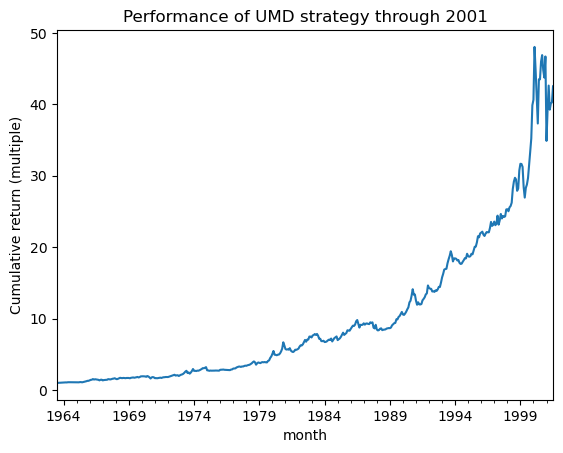

In [3]:
UMD = numpy.log(1+FF3F['umd'])
numpy.exp(UMD.cumsum()).plot(title="Performance of UMD strategy through 2001",ylabel="Cumulative return (multiple)");

**HML**: The return to a dollar-neutral strategy that goes long value stocks and short growth stocks 
<br>
*(and holds the proceeds from the short sale in cash earning zero interest)*

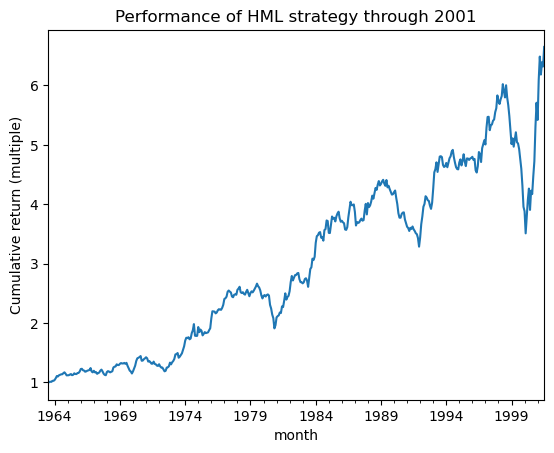

In [4]:
HML = numpy.log(1+FF3F['hml'])
numpy.exp(HML.cumsum()).plot(title="Performance of HML strategy through 2001",ylabel="Cumulative return (multiple)");

**"Combo"**: The return to a strategy that maintains 50% dollar weighting on UMD, and 50% on HML. Some practitioners (notably AQR) advocate this form of diversification across strategies as a way to get a better risk/return tradeoff.

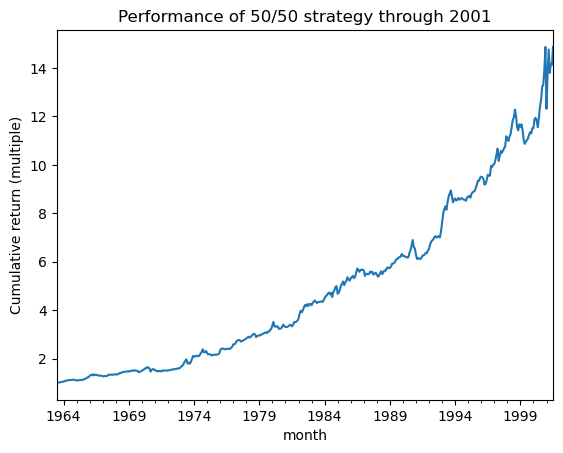

In [5]:
Combo = numpy.log(1 + 0.5*UMD + 0.5*HML)
numpy.exp(Combo.cumsum()).plot(title="Performance of 50/50 strategy through 2001",ylabel="Cumulative return (multiple)");

For each of the three strategies mentioned above (UMD, HML, and "Combo"), perform the following steps:
- (a) Calculate the 12-month 5% value-at-risk ignoring any time-series effects in volatility (that is, assuming that volatility is a constant number).
- (b) Use Engle’s ARCH-LM test to show that the analysis in (a) is actually invalid.
- (c) Estimate a GARCH(1,1) model of the volatility of the strategy’s returns.
- (d) Show that when we apply Engle’s ARCH-LM test to the residuals from the model in part (c), we fail to reject the null hypothesis, and explain what this means.
- (e) Plot the GARCH estimates of conditional volatility over time.
- (f) Calculate the 12-month 5% value-at-risk based on the GARCH estimates. 

Final questions: 
- Why is your answer to (f) always greater than your answer to (a)?
- Why is your answer to (f) lower for the "Combo" strategy, than for either of the two strategies UMD or HML on its own?

### UMD

In [6]:
mean = 12*UMD.mean()
vol = math.sqrt(12)*UMD.std()
percentile = mean - 1.645*vol
VAR = -percentile
print("12-month 5% VAR: " + '%10.4f' % VAR )

12-month 5% VAR:     0.1254


In [7]:
het_arch(UMD,nlags=1)

(18.490533655583132,
 1.7075029167289316e-05,
 19.18747575858448,
 1.472775359857879e-05)

In [8]:
het_arch(UMD)

(63.25236584643144,
 8.740194058905323e-10,
 7.186502027529869,
 1.5878633394513085e-10)

In [9]:
GARCH11_results = arch.arch_model(100*UMD,vol='garch',p=1,q=1).fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1801.2942530307537
Iteration:      2,   Func. Count:     14,   Neg. LLF: 24146.418393688004
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1544.8940411606554
Iteration:      4,   Func. Count:     28,   Neg. LLF: 1203.6790351143013
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1714.1445166938302
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1203.6487664272493
Iteration:      7,   Func. Count:     45,   Neg. LLF: 1203.6474483760821
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1203.6473781425414
Iteration:      9,   Func. Count:     54,   Neg. LLF: 1203.6473780362808
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1203.6473781425414
            Iterations: 9
            Function evaluations: 54
            Gradient evaluations: 9


In [10]:
GARCH11_resid_standardized = GARCH11_results.resid / GARCH11_results.conditional_volatility
het_arch( GARCH11_resid_standardized , nlags=1 )

(0.0013052492545702066,
 0.9711801099548606,
 0.0012995281968708203,
 0.9712591568616423)

In [11]:
het_arch( GARCH11_resid_standardized )

(7.096373034490036, 0.7163165074369288, 0.7033401075550226, 0.7215635539279712)

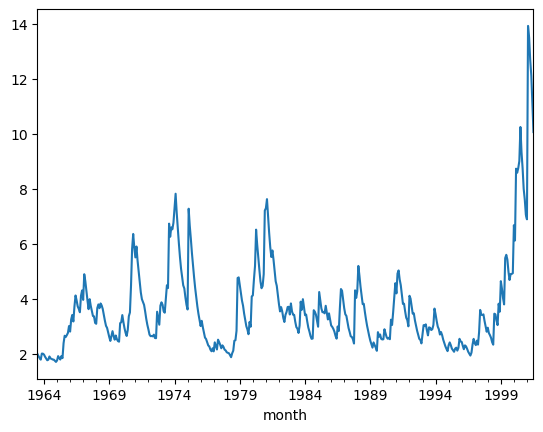

In [12]:
GARCH11_results.conditional_volatility.plot();

In [13]:
forecast = GARCH11_results.forecast(horizon=12)
mean = forecast.mean.iloc[-1].sum() / 100
vol = math.sqrt( forecast.variance.iloc[-1].sum() ) / 100
percentile = mean - 1.645*vol
VAR = -percentile
print("12-month 5% VAR: " + '%10.4f' % VAR )

12-month 5% VAR:     0.4644


### HML

In [14]:
mean = 12*HML.mean()
vol = math.sqrt(12)*HML.std()
percentile = mean - 1.645*vol
VAR = -percentile
print("12-month 5% VAR: " + '%10.4f' % VAR )

12-month 5% VAR:     0.1155


In [15]:
het_arch(HML,nlags=1)

(49.40958636298921,
 2.0772807283035952e-12,
 55.170883169969514,
 5.519337725356899e-13)

In [16]:
het_arch(HML)

(116.2412257309813,
 2.924455367692298e-20,
 15.322699913468334,
 1.4551519671662104e-23)

In [17]:
GARCH11_results = arch.arch_model(100*HML,vol='garch',p=1,q=1).fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2073.5513177835546
Iteration:      2,   Func. Count:     13,   Neg. LLF: 514087838.8010448
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1290.9778680100894
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1100.421641662413
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1098.306576675789
Iteration:      6,   Func. Count:     39,   Neg. LLF: 1091.4077401158227
Iteration:      7,   Func. Count:     45,   Neg. LLF: 1089.6328647356295
Iteration:      8,   Func. Count:     51,   Neg. LLF: 1089.5183556077031
Iteration:      9,   Func. Count:     56,   Neg. LLF: 1089.516179660301
Iteration:     10,   Func. Count:     61,   Neg. LLF: 1089.5161748409373
Iteration:     11,   Func. Count:     66,   Neg. LLF: 1089.5161715249271
Iteration:     12,   Func. Count:     70,   Neg. LLF: 1089.516171525076
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1089.5161715249271
            Iteratio

In [18]:
GARCH11_resid_standardized = GARCH11_results.resid / GARCH11_results.conditional_volatility
het_arch( GARCH11_resid_standardized , nlags=1 )

(1.0080999635034038, 0.3153584596067204, 1.005902266378427, 0.3164207829051215)

In [19]:
het_arch( GARCH11_resid_standardized )

(7.717819790131423, 0.6563780025868623, 0.7660154634293801, 0.6617118009384415)

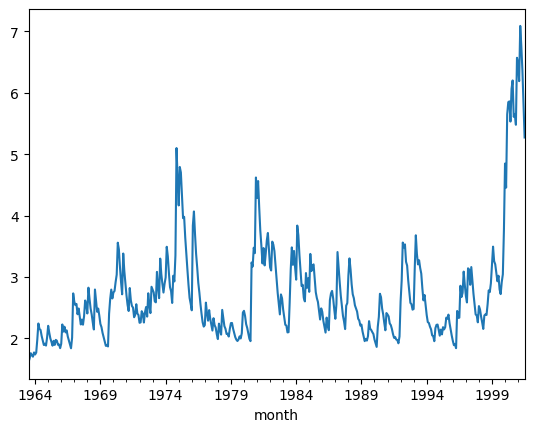

In [20]:
GARCH11_results.conditional_volatility.plot();

In [21]:
forecast = GARCH11_results.forecast(horizon=12)
mean = forecast.mean.iloc[-1].sum() / 100
vol = math.sqrt( forecast.variance.iloc[-1].sum() ) / 100
percentile = mean - 1.645*vol
VAR = -percentile
print("12-month 5% VAR: " + '%10.4f' % VAR )

12-month 5% VAR:     0.2322


In [22]:
mean = 12*Combo.mean()
vol = math.sqrt(12)*Combo.std()
percentile = mean - 1.645*vol
VAR = -percentile
print("12-month 5% VAR: " + '%10.4f' % VAR )

12-month 5% VAR:     0.0576


In [23]:
het_arch(Combo,nlags=1)

(77.19955104852923,
 1.545286654604809e-18,
 92.52522343373053,
 4.66073671805625e-20)

In [24]:
het_arch(Combo)

(79.58369196023726,
 6.057851735657976e-13,
 9.443916596894299,
 2.953484867105051e-14)

In [25]:
GARCH11_results = arch.arch_model(100*Combo,vol='garch',p=1,q=1).fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2335.0934951238696
Iteration:      2,   Func. Count:     14,   Neg. LLF: 85856.21510575747
Iteration:      3,   Func. Count:     20,   Neg. LLF: 952.5443752382259
Iteration:      4,   Func. Count:     27,   Neg. LLF: 953.430764922708
Iteration:      5,   Func. Count:     33,   Neg. LLF: 938.0579597416331
Iteration:      6,   Func. Count:     39,   Neg. LLF: 937.4646231653442
Iteration:      7,   Func. Count:     44,   Neg. LLF: 937.3904329572929
Iteration:      8,   Func. Count:     49,   Neg. LLF: 937.3872134690057
Iteration:      9,   Func. Count:     54,   Neg. LLF: 937.3869984586349
Iteration:     10,   Func. Count:     58,   Neg. LLF: 937.3869984590128
Optimization terminated successfully    (Exit mode 0)
            Current function value: 937.3869984586349
            Iterations: 10
            Function evaluations: 58
            Gradient evaluations: 10


In [26]:
GARCH11_resid_standardized = GARCH11_results.resid / GARCH11_results.conditional_volatility
het_arch( GARCH11_resid_standardized , nlags=1 )

(0.25631448185496897,
 0.6126635370420397,
 0.2553338169235444,
 0.6135893763149208)

In [27]:
het_arch( GARCH11_resid_standardized )

(3.986051632907789, 0.9479740238672933, 0.3922943099994016, 0.9499640257353479)

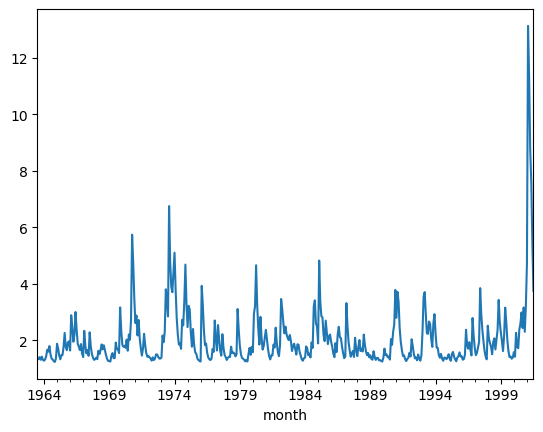

In [28]:
GARCH11_results.conditional_volatility.plot();

In [29]:
forecast = GARCH11_results.forecast(horizon=12)
mean = forecast.mean.iloc[-1].sum() / 100
vol = math.sqrt( forecast.variance.iloc[-1].sum() ) / 100
percentile = mean - 1.645*vol
VAR = -percentile
print("12-month 5% VAR: " + '%10.4f' % VAR )

12-month 5% VAR:     0.1445


### Final Question

1. The GARCH model accounts for the time-varying nature of volatility. In periods of high market volatility, such as during financial crises or market turmoil, the GARCH model will forecast higher future volatility compared to a constant volatility model that uses a long-term average. The higher forecasted volatility results in a higher Var, reflecting an increased risk of large losses. 
2. The "Combo" strategy, which combines UMD and HML strategies, likely benefits from diversification. When combining different investment strategies or assets, the overall portfolio volatility can decrease if the individual components are not perfectly correlated. This concept is a fundamental principle of portfolio theory. Essentially, when one strategy experiences high volatility or losses, the other might not, thus mitigating the overall risk of the combined portfolio. Therefore, the "Combo" strategy's lower VaR compared to UMD or HML individually is an indication of the risk-reducing benefits of diversification within the portfolio, reflecting the reduced likelihood of extreme negative returns.